In [46]:
# Initialising required libraries
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from datetime import datetime
from sklearn import metrics

In [47]:
df_Population = pd.read_csv("PCDA_UNCLEANED/Population_UK_Quarterly.csv")
df_Population

,DATE,Population
0,3/31/1989,28265000.0
1,6/30/1989,28301000.0
2,9/30/1989,28328000.0
3,12/31/1989,28388000.0
4,3/31/1990,28395000.0
...,...,...
131,12/31/2021,32600000.0
132,3/31/2022,32574000.0
133,6/30/2022,32588000.0
134,9/30/2022,NaN


In [48]:
df_Population=df_Population.dropna()
df_Population
df_Population['DATE'] = pd.to_datetime(df_Population['DATE'])

C:\Users\Students\AppData\Local\Temp\ipykernel_19220\2636629964.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Population['DATE'] = pd.to_datetime(df_Population['DATE'])


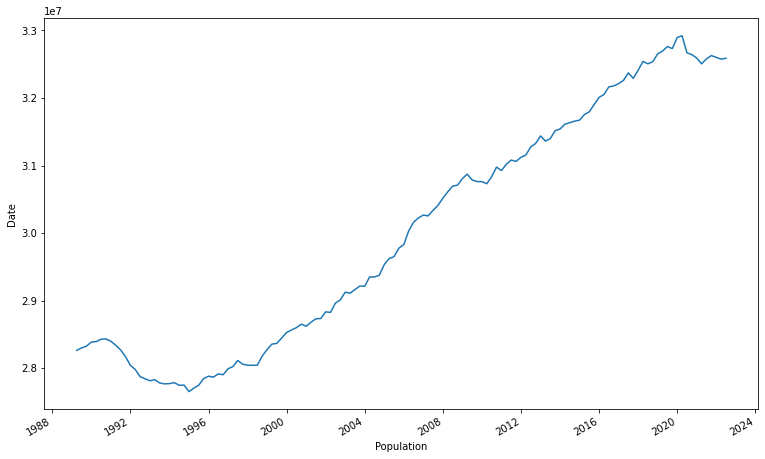

In [49]:
plt.plot(df_Population['DATE'], df_Population['Population'])
plt.xticks(rotation=30, ha='right')
plt.xlabel("Population")
plt.ylabel("Date")
plt.rcParams['figure.figsize']=(12.8,7.2)

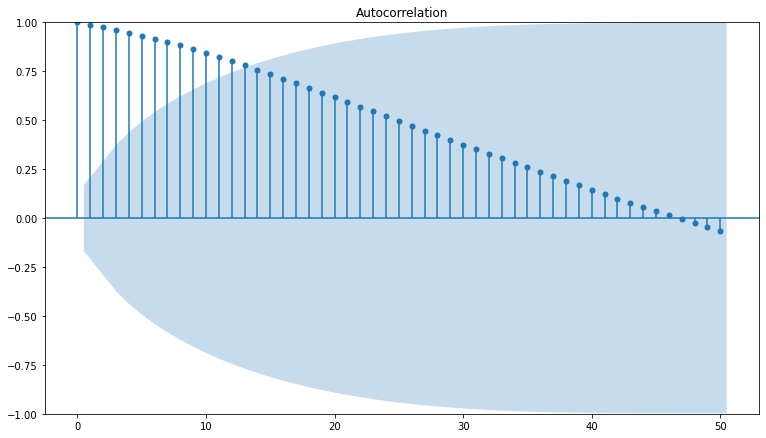

In [50]:
from statsmodels.graphics.tsaplots import plot_acf
acf_plot = plot_acf(df_Population['Population'],lags=50)

### According to the ACF plot, the autocorrelations are not declining quickly toward zero which indicates a trend component. As this is quarterly data and there are no significant spikes at every 4th lag, there is no seasonal component

### Due the pressence of Trend component, we can fit the data with below models
    1. Holt's linear Exponential 
    2. Damped trend Exponential
    3. Simple Linear Regression
    4. ARIMA

In [51]:
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import Holt,ExponentialSmoothing

# Split the data in to test and Train

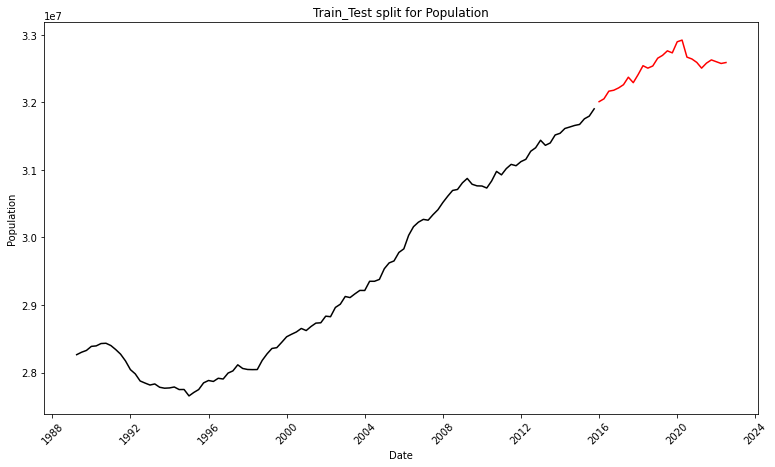

In [52]:
x1 = df_Population.loc[:, df_Population.columns == 'DATE'].to_numpy()
y1 = df_Population.loc[:, df_Population.columns == 'Population'].to_numpy()
x1_train, x1_test,y1_train, y1_test = train_test_split(x1,y1, test_size=0.20, shuffle=False)
x1_train
plt.plot(x1_train,y1_train, color = "black")
plt.plot(x1_test,y1_test, color = "red")
plt.ylabel('Population')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train_Test split for Population")
plt.rcParams['figure.figsize']=(12.8,7.2)
plt.show()

## It will be interesting to watch for individual performance of the model, as train data accounts for 2008 economic depression and test data accounts for pendamic depression

## Holt's linear Exponential model

In [53]:
def holt(x1,y1,y1_train,y1_test, period,x1_train,x1_test):
    plt1 = plt.plot(x1,y1,color='black')
    fit1 = Holt(y1_train).fit()
    fcast1 = fit1.forecast(period)
    #mse1_fit = ((fit1.fittedvalues - y1_train.squeeze()) ** 2).mean()
    #mse1_acc = ((fcast1 - y1_test.squeeze()) ** 2).mean()
    MAPE_fit= metrics.mean_absolute_percentage_error(y1_train, fit1.fittedvalues)
    MAPE_acc = metrics.mean_absolute_percentage_error(y1_test, fcast1)
    print('The MAPE for Model fit is',MAPE_fit)
    print('The MAPE for Model Acc is ',MAPE_acc)
    #print('The Root Mean Squared Error of Model fit is {}'.format(round(np.sqrt(mse1_fit), 2)))
    #print('The Root Mean Squared Error of Model accuracy is {}'.format(round(np.sqrt(mse1_acc), 2)))
    plt2 = plt.plot(x1_train,fit1.fittedvalues, color='blue')
    plt3 = plt.plot(x1_test,fcast1,color='red', marker="o")
    ax = plt.gca()
    print(fit1.summary())
    ax.legend([plt1[0],plt2[0],plt3[0]],["Actual","Holt's fit","Holt's Predict"])
    plt.xticks(rotation=30, ha='right')
    plt.title("Holt’s Linear Smoothing")
    plt.show()

The MAPE for Model fit is 0.0015693342526265505
The MAPE for Model Acc is  0.007152764290843179
                              Holt Model Results                              
Dep. Variable:                  endog   No. Observations:                  107
Model:                           Holt   SSE                   354807773745.613
Optimized:                       True   AIC                           2353.655
Trend:                       Additive   BIC                           2364.347
Seasonal:                        None   AICC                          2354.495
Seasonal Periods:                None   Date:                 Mon, 12 Dec 2022
Box-Cox:                        False   Time:                         21:03:04
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.971428

C:\Users\Students\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


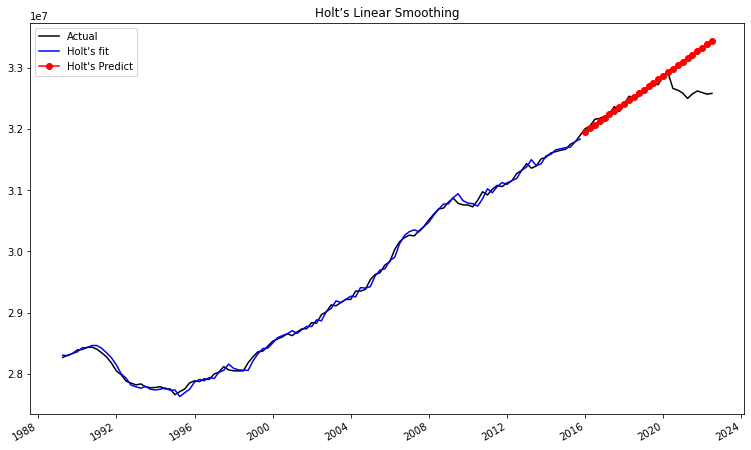

In [54]:
holt(x1,y1, y1_train,y1_test,len(x1_test),x1_train,x1_test)

### The level smoothing parameter is "0.97" which indicates that a higher weight is assigned to the most recent observations.
### The trend smoothing parameter is "0.20" indicates that the slope of the time series is hardly changing.
### The MAPE for Model Acc is "0.007", which indicate model peformance is good.

In [55]:
def damped(x1,y1,y1_train,y1_test, period,x1_train,x1_test):
    plt1 = plt.plot(x1,y1,color='black')
    fit1 = ExponentialSmoothing(y1_train,trend='add',seasonal=None, damped_trend=True).fit()
    fcast1 = fit1.forecast(period)
   # mse1_fit = ((fit1.fittedvalues - y1_train.squeeze()) ** 2).mean()
   # mse1_acc = ((fcast1 - y1_test.squeeze()) ** 2).mean()
    MAPE_fit= metrics.mean_absolute_percentage_error(y1_train, fit1.fittedvalues)
    MAPE_acc = metrics.mean_absolute_percentage_error(y1_test, fcast1)
    print("The MAPE for Model fit is {}",MAPE_fit)
    print("The MAPE for Model Acc is {}",MAPE_acc)
    #print('The Root Mean Squared Error of Model fit is {}'.format(round(np.sqrt(mse1_fit), 2)))
    #print('The Root Mean Squared Error of Model accuracy is {}'.format(round(np.sqrt(mse1_acc), 2)))
    plt2 = plt.plot(x1_train,fit1.fittedvalues, color='blue')
    plt3 = plt.plot(x1_test,fcast1,color='red', marker="o")
    print(fit1.summary())
    ax = plt.gca()
    ax.legend([plt1[0],plt2[0],plt3[0]],["Actual","Damped fit","Damped Predict"])
    plt.xticks(rotation=30, ha='right')
    plt.title("Damped Exponential Smoothing")
    plt.show()

The MAPE for Model fit is {} 0.001587308692415461
The MAPE for Model Acc is {} 0.005647259670397891
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                  107
Model:             ExponentialSmoothing   SSE                   354446730897.386
Optimized:                         True   AIC                           2355.546
Trend:                         Additive   BIC                           2368.911
Seasonal:                          None   AICC                          2356.678
Seasonal Periods:                  None   Date:                 Mon, 12 Dec 2022
Box-Cox:                          False   Time:                         21:03:05
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_lev

C:\Users\Students\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


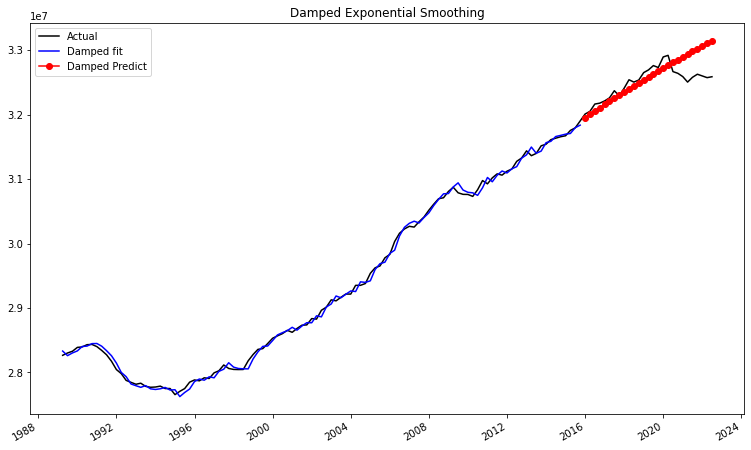

In [56]:
damped(x1,y1, y1_train,y1_test,len(x1_test),x1_train,x1_test)

### The level smoothing parameter is "0.99" which indicates that a higher weight is assigned to the most recent observations.
### The trend smoothing parameter is "0.16" indicates that the slope of the time series is very less changing.
### The damping smoothing parameter is "0.99" which indicates that less or hardly any damping is applied.
### The MAPE for Model Acc is "0.0056", which indicate model peformance is good.

# Simple Linear Regression

In [57]:
# Importing Linear Regression model from scikit learn
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [58]:
df_Population['DateIndex'] = np.arange(len(df_Population.index))
X = df_Population.loc[:, df_Population.columns == 'DateIndex']
y = df_Population.loc[:, df_Population.columns == 'Population']

X = np.array(X).reshape((-1, 1))
X_train, X_test,y_train, y_test = train_test_split(X,y, test_size=0.20, shuffle=False)
X_test
X_test = np.array(X_test).reshape((-1, 1))

C:\Users\Students\AppData\Local\Temp\ipykernel_19220\3043033581.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Population['DateIndex'] = np.arange(len(df_Population.index))


In [59]:
# fit the regression model
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             Population   R-squared (uncentered):                   0.783
Model:                            OLS   Adj. R-squared (uncentered):              0.781
Method:                 Least Squares   F-statistic:                              382.9
Date:                Mon, 12 Dec 2022   Prob (F-statistic):                    5.68e-37
Time:                        21:03:06   Log-Likelihood:                         -1910.1
No. Observations:                 107   AIC:                                      3822.
Df Residuals:                     106   BIC:                                      3825.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          4.241e+05   2.17e+04     19.567      0.000    3.81e+05    4.67e+05
==============================================================================
Omnibus:                       26.475   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                5.770
Skew:                           0.085   Prob(JB):                       0.0558
Kurtosis:                       1.875   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
y_pred = model.predict(X_test)
y_pred

array([45381140.3135796 , 45805263.12024856, 46229385.92691753,
       46653508.7335865 , 47077631.54025546, 47501754.34692444,
       47925877.15359341, 48349999.96026237, 48774122.76693134,
       49198245.57360031, 49622368.38026927, 50046491.18693824,
       50470613.99360722, 50894736.80027618, 51318859.60694515,
       51742982.41361412, 52167105.22028308, 52591228.02695205,
       53015350.83362103, 53439473.64028999, 53863596.44695896,
       54287719.25362793, 54711842.06029689, 55135964.86696586,
       55560087.67363483, 55984210.4803038 , 56408333.28697277])

In [61]:
MAPE_train=metrics.mean_absolute_percentage_error(y_train, model.fittedvalues)
print("The MAPE for Model fit is",MAPE_train)
MAPE_test=metrics.mean_absolute_percentage_error(y_test, y_pred)
print("The MAPE for Model Acc is",MAPE_test)

The MAPE for Model fit is 0.390969804042287
The MAPE for Model Acc is 0.5654301823313536


In [62]:
y_train = np.array(y_train).reshape((-1, 1))
model.fittedvalues = np.array(model.fittedvalues).reshape((-1, 1))

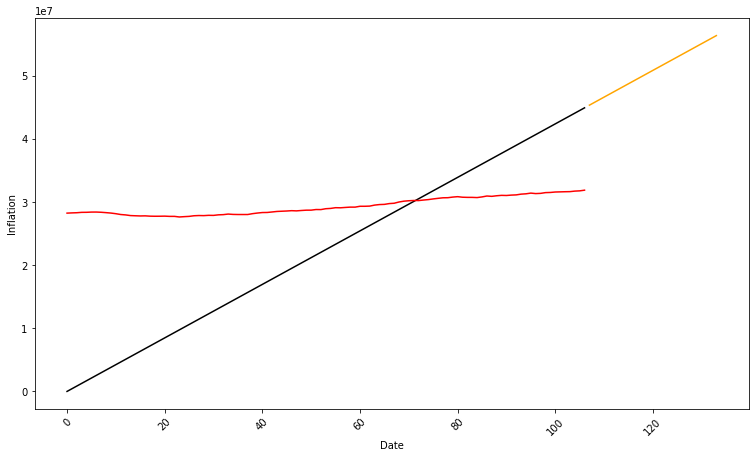

In [63]:
plt.plot(X_train,model.fittedvalues, color = "black")
plt.plot(X_train,y_train, color = "red")
plt.plot(X_test,y_pred, color = "Orange")
plt.ylabel('Inflation')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.rcParams['figure.figsize']=(12.8,7.2)
plt.show()

# Model Assumptions
## 1.	First, we assume that the relationship between the forecast variable and the predictor variable is linear
### The relationship between the forecast variable “population” and the predictor variable is linear.
## 2.Second, we make the following assumptions about the errors:     
        * Residuals are normally distributed
        * Residuals have constant variance 
        * Residual terms are independent

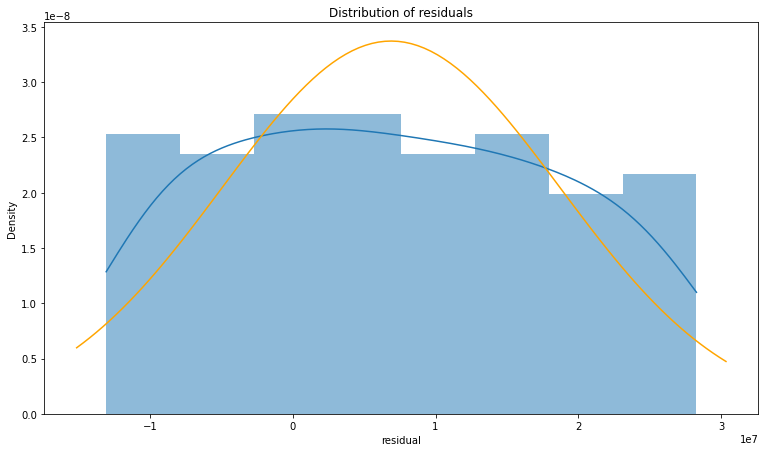

In [64]:
from scipy import stats
mu, std = stats.norm.fit(model.resid)
mu, std
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

fig, ax = plt.subplots()
# plot the residuals
sns.histplot(x=model.resid, ax=ax, stat="density", linewidth=0, kde=True)
ax.set(title="Distribution of residuals", xlabel="residual")

# plot corresponding normal curve
xmin, xmax = plt.xlim() # the maximum x values from the histogram above
x = np.linspace(xmin, xmax, 100) # generate some x values
p = stats.norm.pdf(x, mu, std) # calculate the y values for the normal curve
sns.lineplot(x=x, y=p, color="orange", ax=ax)
plt.show()

## According to the histogram, the residuals appear normally distributed, The assumption is true

[Text(0.5, 0, 'Residuals'), Text(0, 0.5, 'Predicted Values')]

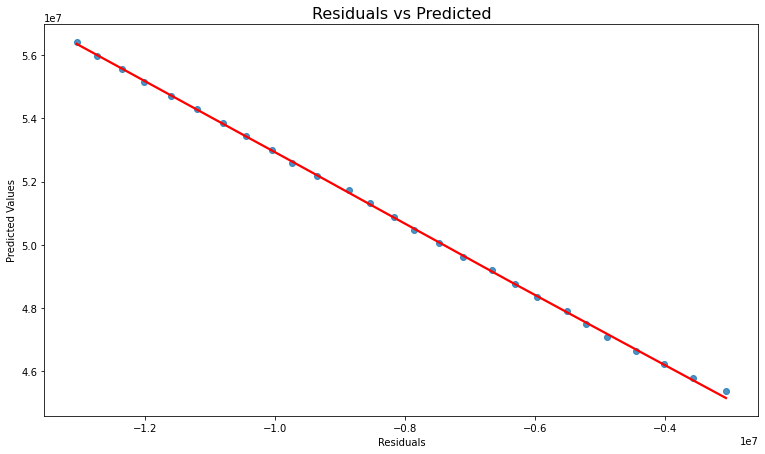

In [65]:
pred_resid = model.resid.tail(len(y_pred))

#Residual Vs Predicted Plot
fig, ax = plt.subplots(1,1)
sns.regplot(x=pred_resid, y=y_pred, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Residuals vs Predicted', fontsize=16)
ax.set(xlabel='Residuals', ylabel='Predicted Values')

## The residual vs. predicted value scatterplot shows a pattern that indicates that the equal variances assumption is not correct.

In [66]:
#perform Durbin-Watson test
from statsmodels.stats.stattools import durbin_watson
durbin_watson(model.resid)

0.0008241688101153654

## As the Durbin-Watson statistic ranges from 0-4. The DW statistic close to zero indicate that there is positive serial correlation

# Model Evaluation
## 1.	Is the model logical? 
### The model is logical because the slope is positive which makes sense. With the increase in time there is increase in Population
## 2.	Is the slope term statistically significant? 
### The p-value for the slope term is less than alpha, so independent variable is a significant predictor
## 3.	What percent of the variation in the dependent variable is explained by variation in the independent variable 
### R2 = 78% so 78% of the variation in the dependent variable is explained by the independent variable

## ARIMA 

In [24]:
pip install pmdarima

In [25]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.model_selection import train_test_split

In [26]:
df_Population.head()

,DATE,Population,DateIndex
0,1989-03-31,28265000.0,0
1,1989-06-30,28301000.0,1
2,1989-09-30,28328000.0,2
3,1989-12-31,28388000.0,3
4,1990-03-31,28395000.0,4


### Check if the data is stationary using Dickey-Fuller test 

In [27]:
ad_fuller_result = adfuller(df_Population['Population'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 0.2174415102520379
p-value: 0.9732230428305747


### The p value is higher than alpha so we cannot reject null hypothesis and must assume the data is not stationary

### Differencing can be done to make the data stationary 

In [28]:
df_Population['Population_diff'] = df_Population['Population'] - df_Population['Population'].shift(1)

C:\Users\Students\AppData\Local\Temp\ipykernel_19220\842193883.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Population['Population_diff'] = df_Population['Population'] - df_Population['Population'].shift(1)


In [29]:
df_Population['Population_diff'].head()

0        NaN
1    36000.0
2    27000.0
3    60000.0
4     7000.0
Name: Population_diff, dtype: float64

In [30]:
df_Population = df_Population.dropna()
df_Population

,DATE,Population,DateIndex,Population_diff
1,1989-06-30,28301000.0,1,36000.0
2,1989-09-30,28328000.0,2,27000.0
3,1989-12-31,28388000.0,3,60000.0
4,1990-03-31,28395000.0,4,7000.0
5,1990-06-30,28430000.0,5,35000.0
...,...,...,...,...
129,2021-06-30,32579000.0,129,74000.0
130,2021-09-30,32627000.0,130,48000.0
131,2021-12-31,32600000.0,131,-27000.0
132,2022-03-31,32574000.0,132,-26000.0


### Check again if the differenced data is stationary 

In [31]:
ad_fuller_result = adfuller(df_Population['Population_diff'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -4.019870228431482
p-value: 0.0013099652852437496


### The p value is lower than alpha so we can assume that the data is stationary 

<AxesSubplot:>

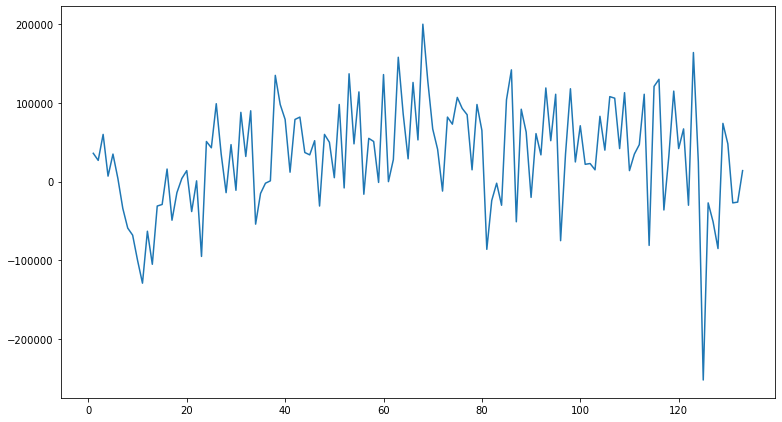

In [32]:
#viewing the stationary data 
df_Population['Population_diff'].plot()

### Plotting ACF and PACF of differenced data to find which ARIMA model to choose 

C:\Users\Students\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


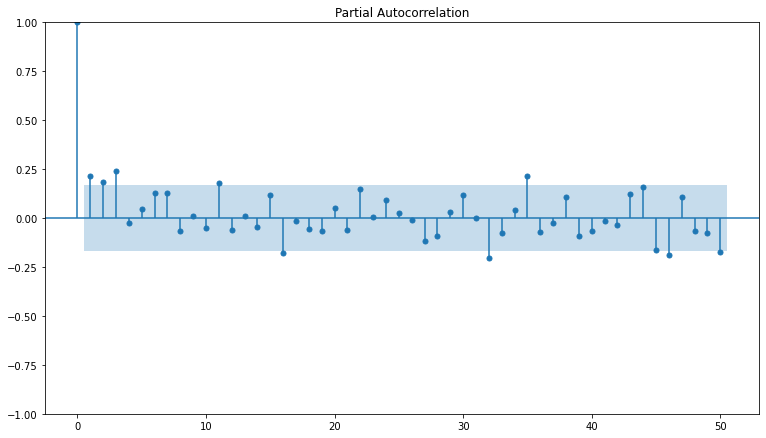

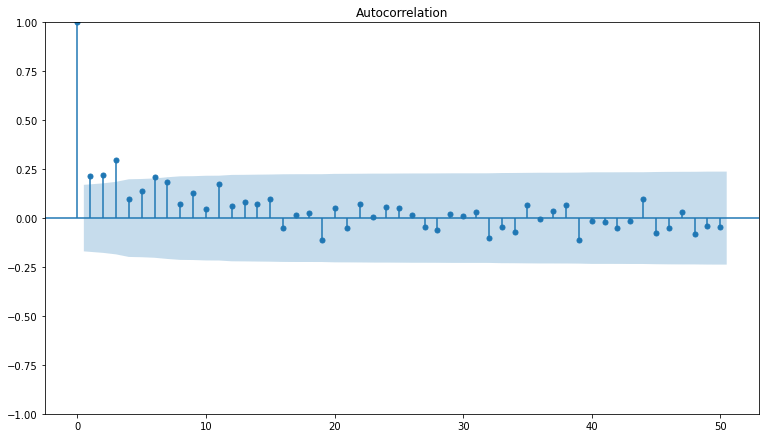

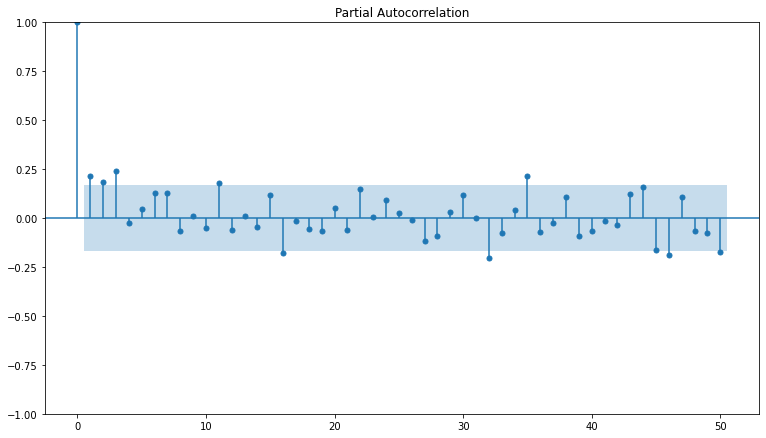

In [33]:
plot_acf(df_Population['Population_diff'],lags=50)
plot_pacf(df_Population['Population_diff'],lags=50)

### The arima model can be split up into AR(p), I(d) and MA(q). In the PACF graph, we can see three significant lags within the first 5 lags, making the AR equal to 3. In the ACF graph, we also see three significant lags, making the MA equal to 3. The I or differencing term in the arima model is equal to 1 since we did one level of differencing to make the data stationary. This makes our model ARIMA(3,1,3). Next, we build the model based on these specifications.

In [34]:
train = df_Population.loc[:106]
test = df_Population.loc[107:]

In [35]:
train

,DATE,Population,DateIndex,Population_diff
1,1989-06-30,28301000.0,1,36000.0
2,1989-09-30,28328000.0,2,27000.0
3,1989-12-31,28388000.0,3,60000.0
4,1990-03-31,28395000.0,4,7000.0
5,1990-06-30,28430000.0,5,35000.0
...,...,...,...,...
102,2014-09-30,31657000.0,102,23000.0
103,2014-12-31,31672000.0,103,15000.0
104,2015-03-31,31755000.0,104,83000.0
105,2015-06-30,31795000.0,105,40000.0


In [36]:
test

,DATE,Population,DateIndex,Population_diff
107,2015-12-31,32009000.0,107,106000.0
108,2016-03-31,32051000.0,108,42000.0
109,2016-06-30,32164000.0,109,113000.0
110,2016-09-30,32178000.0,110,14000.0
111,2016-12-31,32213000.0,111,35000.0
112,2017-03-31,32260000.0,112,47000.0
113,2017-06-30,32371000.0,113,111000.0
114,2017-09-30,32290000.0,114,-81000.0
115,2017-12-31,32411000.0,115,121000.0
116,2018-03-31,32541000.0,116,130000.0


In [37]:
model = ARIMA(train['Population'], order = (3, 1, 3))
results = model.fit()

C:\Users\Students\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Students\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Students\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Students\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Students\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to 

In [38]:
prediction = results.predict(start=106, end=133, dynamic=False)
prediction.columns = ["predicted_values"]
test["predicted_values"] = prediction

C:\Users\Students\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Students\AppData\Local\Temp\ipykernel_19220\2371923517.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted_values"] = prediction


In [39]:
test

,DATE,Population,DateIndex,Population_diff,predicted_values
107,2015-12-31,32009000.0,107,106000.0,3.190145e+07
108,2016-03-31,32051000.0,108,42000.0,3.189075e+07
109,2016-06-30,32164000.0,109,113000.0,3.189818e+07
110,2016-09-30,32178000.0,110,14000.0,3.189266e+07
111,2016-12-31,32213000.0,111,35000.0,3.189397e+07
112,2017-03-31,32260000.0,112,47000.0,3.189499e+07
113,2017-06-30,32371000.0,113,111000.0,3.188987e+07
114,2017-09-30,32290000.0,114,-81000.0,3.189670e+07
115,2017-12-31,32411000.0,115,121000.0,3.188685e+07
116,2018-03-31,32541000.0,116,130000.0,3.189697e+07


In [40]:
test = test.dropna()
test

,DATE,Population,DateIndex,Population_diff,predicted_values
107,2015-12-31,32009000.0,107,106000.0,3.190145e+07
108,2016-03-31,32051000.0,108,42000.0,3.189075e+07
109,2016-06-30,32164000.0,109,113000.0,3.189818e+07
110,2016-09-30,32178000.0,110,14000.0,3.189266e+07
111,2016-12-31,32213000.0,111,35000.0,3.189397e+07
112,2017-03-31,32260000.0,112,47000.0,3.189499e+07
113,2017-06-30,32371000.0,113,111000.0,3.188987e+07
114,2017-09-30,32290000.0,114,-81000.0,3.189670e+07
115,2017-12-31,32411000.0,115,121000.0,3.188685e+07
116,2018-03-31,32541000.0,116,130000.0,3.189697e+07


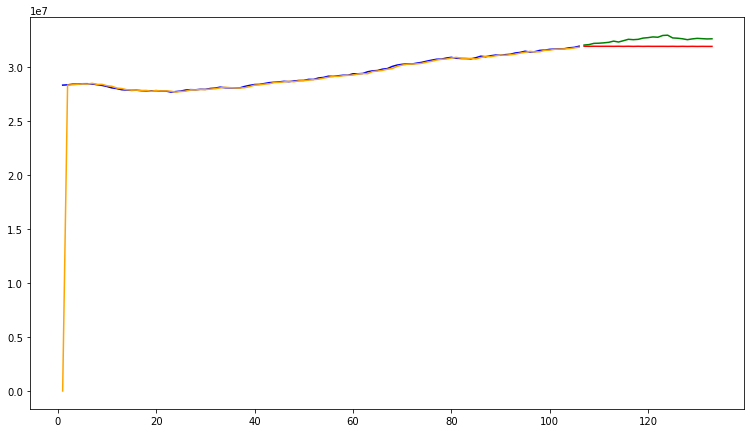

In [41]:
plt.plot(train['Population'], color = 'Blue', label = "Train")
plt.plot(test['Population'], color = 'Green', label = "Test")
plt.plot(test['predicted_values'], color ='Red', label = "Prediction")
plt.plot(results.fittedvalues, color='Orange')

In [42]:
MAPE_test=metrics.mean_squared_error(test['Population'], test['predicted_values'])
MAPE_train=metrics.mean_absolute_percentage_error(train['Population'], results.fittedvalues)
print("The MAPE for Model Accuracy(test) is",MAPE_test)
print("The MAPE for Model fit(train) is",MAPE_train)

The MAPE for Model Accuracy(test) is 431647430038.4929
The MAPE for Model fit(train) is 0.011362883548129747


### The predicted values are not able to identify the curves in the graph and are graphed as more of a straight line. The MAPE for model fit is low showing that it is able to fit to the train data well. Model accuracy is very high which is not good, meaning that the model is not able to fit the test data well. 

## Among the Holt's, Damped, simple regression, and ARIMA, Damped model performed better. So we now forecast the Interest rate for next two quarter using Damped model.

# Model Predictions for next two quarters

In [43]:
fit_damp = ExponentialSmoothing(df_Population['Population'],trend='add',seasonal=None, damped_trend=True).fit()
fcast_damp = fit_damp.forecast(2)

C:\Users\Students\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Students\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Students\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [44]:
fcast_damp =  fcast_damp.to_frame()
fcast_damp.columns = ['Population']
fcast_damp

,Population
133,3.258952e+07
134,3.259109e+07
